In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import time
import copy
import multiprocessing as mp
import random

from scipy import sparse
from sklearn.metrics import roc_auc_score

pd.set_option('display.max_columns', 100)

In [2]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

# Read Data

In [3]:
# path = 'C:/Users/robin.opdam/Google Drive/Thesis (Msc)/Thesis_shared_files/'
path = '/Users/Robin/Google Drive/Thesis (Msc)/Thesis_shared_files/'

## Amazon Fashion

In [4]:
data_path = 'data/Amazon/'
# file_name = 'Amazon_full' 
# file_name = 'Amazon_05_users' 
# file_name = 'Amazon_01_users'
# file_name = 'Amazon_005_users'
file_name = 'Amazon_001_users'

## MovieLens

In [5]:
# data_path = 'data/ML/'
# file_name = 'ML_full' 
# file_name = 'ML_05_users'
# file_name = 'ML_01_users'
# file_name = 'ML_005_users'
# file_name = 'ML_001_users'

In [6]:
df = pd.read_pickle(path + data_path + file_name)
df.head()

,user,item,datetime,rating,item_id,user_id
5282697,A1QP7FHEZRZ1LZ,B00HMXYKMM,2017-02-08,5.0,168923,238328
8819596,A1QP7FHEZRZ1LZ,B01A88MEV6,2017-04-10,5.0,335203,238328
3335926,A1QP7FHEZRZ1LZ,B007900UZY,2017-04-10,5.0,77864,238328
6822032,A1QP7FHEZRZ1LZ,B00RI9TL7E,2017-04-10,4.0,245981,238328
4500311,A1QP7FHEZRZ1LZ,B00DBUVIVQ,2017-04-10,5.0,131704,238328


# Data Prep

## Create new ids

In [7]:
df['item_id'] = df.item.astype('category').cat.codes
df['user_id'] = df.user.astype('category').cat.codes

## Train Test Split
### Leave last item out of subset of users

In [8]:
def leave_last_x_out(full_data, n_users, leave_out=1, seed=1234):
    # Input: data must contain user_id
    # Output: full_data = without all entries last entries in leave one out set
    #         leave_one_out_set = data with one user and one item from full_data
    
    full_data['index'] = full_data.index
    user_items_ind = full_data.groupby('user_id')['index'].apply(list)
    np.random.RandomState(seed)
    users = np.random.choice(list(user_items_ind.index), n_users*3, replace=False)
    leave_out_indices = []
    
    user_counter = 0
    indices = user_items_ind.loc[users[user_counter]]
    while user_counter < n_users or len(indices) < leave_out:
        to_leave_out_indices = indices[- leave_out:]
        leave_out_indices.extend(to_leave_out_indices)
        
        user_counter += 1
        indices = user_items_ind.loc[users[user_counter]]
    
    leave_out_set = full_data.loc[leave_out_indices]
    full_data_leave_one_out = full_data.drop(leave_out_indices)
    
    return full_data_leave_one_out.drop(columns=['index']), leave_out_set.drop(columns=['index'])

### Split

In [9]:
total_users = len(df.user_id.unique())
total_items = len(df.item_id.unique())
print('Total Users:', total_users)

Total Users: 12137


In [10]:
test_users = int(0.1*total_users) # Number of users to be used for testing
test_last_items = 1 # Items to be removed from test users in train set and used in test set

val_users = int(0.1*total_users)
val_last_items = 1

In [11]:
train_set, test_set = leave_last_x_out(df, test_users, test_last_items)
train_set, val_set = leave_last_x_out(train_set, val_users, val_last_items)

# Model

## Bayesian Personalized Ranking
- Paper: https://arxiv.org/pdf/1205.2618.pdf
- Code:  https://github.com/valerystrizh/bpr/blob/master/BPR.java

In [12]:
class BPR():
    def __init__(self, total_users, total_items, params):
        self.total_users = total_users
        self.total_items = total_items
        self.nolf = params['nolf']
        self.n_iterations = params['n_iterations']
        self.sample_size = params['sample_size']
        self.seed = params['seed']
        self.alpha = params['alpha']
        self.reg_user = params['reg_user']
        self.reg_item = params['reg_item']
        self.alpha_decay = self.alpha / self.n_iterations
        
        self.model = {}
        self.model['val_auc'] = []
        self.user_items = pd.DataFrame()
        self.train_users = []
        self.train_items = []
        
        self.val_user_items = pd.DataFrame()
        self.val_users = []
        
    def fit(self, train_set, val_set):
        # Init
        s = time.time()
        rstate = np.random.RandomState(self.seed)
        p = np.random.normal(0, .1, (self.total_users, self.nolf))  # users
        q = np.random.normal(0, .1, (self.total_items, self.nolf))  # items
        
        ## Used for sampling
        self.user_items = train_set.groupby('user_id')['item_id'].apply(list)
        self.train_users  = train_set.user_id.unique()
        self.train_items = train_set.item_id.unique()
        
        ## Used for testing
        self.val_user_items = val_set.groupby('user_id')['item_id'].apply(list)
        self.val_users = val_set.user_id.unique()
        
        ## Track losses and alphas used
        loss_list = []
        alphas = []
        
        ## Create samples for all iterations
        all_uij_samples = self.sample()
        
        # Training Loop
        for iteration in range(self.n_iterations):
            it_loss = 0
            uij_samples = all_uij_samples[iteration]
            
            for uij_sample in uij_samples:
                u = uij_sample[0]
                i = uij_sample[1]
                j = uij_sample[2]
                
                ## Calculate the difference between positive and negative item
                diff = np.dot(p[u], (q[i] - q[j]).T)
                
                ## Obtain loss 
                loss_value = - np.log(self.sigmoid(diff))
                regulariser = self.reg_user * np.dot(p[u], p[u]) + self.reg_item * np.dot(q[i],q[i]) + self.reg_item/10 * np.dot(q[j], q[j])
                it_loss += loss_value + regulariser
                
                ## Derivative of the difference for update 
                diff_deriv = self.sigmoid(- diff)
                
                ## Update the factors of the latent features, using their respective derivatives
                ## See http://ethen8181.github.io/machine-learning/recsys/4_bpr.html
                p[u] += self.alpha * (diff_deriv * (q[i] - q[j]) - self.reg_user * p[u])
                q[i] += self.alpha * (diff_deriv * p[u] - self.reg_item * q[i])
                q[j] += self.alpha * (diff_deriv * (-p[u]) - self.reg_item * q[j])
            
            ## Store iteration variables
            self.model['p'] = p
            self.model['q'] = q
            
            if len(val_set) > 0: # TO DO: safe best & early stopping
                val_auc = self.AUC()
                self.model['val_auc'].append(val_auc)
                print('iteration:', iteration, ' loss:', round(it_loss/self.sample_size,6), ' val AUC:', val_auc)#, ' val prec@' + str(val_rank), ':', round(prec_at,5), ' val rec@' + str(val_rank), ':', round(rec_at,5), '  Hits:', hitcount)#'  alpha:', self.alpha)
            else:
                print('iteration:', iteration, ' loss:', round(it_loss/self.sample_size,6))
                
            if iteration > 0:
                self.update_alpha(loss_list[-1], it_loss)
                
            alphas.append(self.alpha)
            loss_list.append(it_loss)
        
        # Store train values
        train_time = time.time() - s
        self.model['train_loss'] = loss_list
        self.model['learning_rate'] = alphas
        self.model['train_time'] = train_time
        
        
    def sample(self):
        n_samples = self.n_iterations
        sample_size = int(self.sample_size)
        print('Creating', str(n_samples), 'samples of length', str(sample_size))
        all_uij_samples = []
        
        for n in range(n_samples):
            uij_samples = []
            for s in range(sample_size):
                u = int(np.random.choice(self.train_users))
                u_items = self.user_items[u]
                i = random.choice(u_items)
                j = int(np.random.choice(self.train_items)) 
                while j in u_items: #neg item j cannot be in the set of pos items of user u
                    j = int(np.random.choice(self.train_items))
                
                uij_samples.append([u,i,j])
                
            all_uij_samples.append(uij_samples)
            
        return all_uij_samples
        
        
    def sigmoid(self, x):
        return 1 / (1 + math.exp(-x))
    
    
    def update_alpha(self, last_loss, it_loss):
        if(last_loss < it_loss): #bold driver
            self.alpha = 0.5 * self.alpha
            return
        
        self.alpha = (1 - self.alpha_decay) * self.alpha
    
    def AUC(self):
        auc = 0.0
        n_users = len(self.val_users)

        for u in self.val_users:
            y_pred = np.dot(self.model['p'][u], self.model['q'].T)
            y_true = np.zeros(self.total_items)
            y_true[self.val_user_items[u]] = 1
            auc += roc_auc_score(y_true, y_pred)
        
        auc /= n_users
        return auc

# Train Model

## Parameters

In [13]:
params = {
"nolf":20, #Size of latent feature vectors
"n_iterations":20, #around 20 is sufficient
"sample_size":len(train_set),
"seed":1234,
"alpha":0.1, # Learning rate
          
#Regularizers, still tweaking the values
"reg_user":0.1,
"reg_item":0.1,
}

In [14]:
file_name

'Amazon_001_users'

In [ ]:
BPR_amazon_001 = BPR(total_users, total_items, params)
BPR_amazon_001.fit(train_set, val_set)

## Store Model

In [15]:
def store_results(results, log_path, res_name, file_name):
        result_info = {'train_loss': results['train_loss'], 'train_speed': results['train_time'], 'lr':results['learning_rate'], 'file':file_name}
        other_info = {'p':results['p'], 'q':results['q']} #'train_size':train_size, 'test_size':test_size, 'val_size':val_size}
        final_log = dict(result_info, **params, **other_info)

        if not os.path.exists(log_path + res_name):
            df_results = pd.DataFrame(columns=final_log.keys())
            print('new results created')

        else:
            df_results = pd.read_pickle(log_path + res_name)
            print('results added')

        df_results = df_results.append(final_log, ignore_index=True)
        pd.to_pickle(df_results, log_path + res_name)

In [97]:
log_path = path + 'Results/BPR/'
res_name = 'BPR_models'
# store_results(BPR_amazon_001.model, log_path, res_name, file_name)

In [98]:
df_res = pd.read_pickle(log_path + res_name)

In [99]:
df_res

,train_loss,train_speed,lr,file,nolf,n_iterations,sample_size,seed,alpha,reg_user,reg_item,p,q
0,"[37738.70952998008, 37367.62344250592, 37031.8...",671.664264,"[0.1, 0.0995, 0.09900250000000001, 0.098507487...",Amazon_001_users,20,20,103218,1234,0.1,0.1,0.1,"[[0.241923070934538, 0.06920972810691176, 0.04...","[[-0.16611172135509036, 0.08507575831053416, -..."
1,"[37394.440958291874, 36425.44377131431, 33992....",145.184773,"[0.1, 0.0995, 0.09900250000000001, 0.098507487...",ML_001_users,20,20,103218,1234,0.1,0.1,0.1,"[[0.04680908775364259, -0.3158303038758334, 0....","[[0.007149378623512315, -0.48439582309758, 0.3..."
2,"[37735.955305987096, 37354.300465847715, 37016...",1340.069238,"[0.1, 0.09975, 0.09950062500000001, 0.09925187...",Amazon_001_users,20,20,103218,1234,0.1,0.1,0.1,"[[0.11660639595035503, -0.27620851231911575, 0...","[[0.2775415538836662, 0.031194809120961516, -0..."
3,"[37404.337474763335, 36450.83321674445, 34028....",133.616620,"[0.1, 0.0995, 0.09900250000000001, 0.098507487...",ML_001_users,20,20,103218,1234,0.1,0.1,0.1,"[[-0.26730203980550665, 0.37941205752800944, -...","[[-0.2754524304552424, 0.35559385306824404, -0..."
4,"[36687.04665538535, 36364.61788972847, 36022.9...",1297.946364,"[0.1, 0.09975, 0.09950062500000001, 0.09925187...",Amazon_001_users,20,20,103218,1234,0.1,0.1,0.1,"[[0.022538348429418188, 0.5387829961733387, -0...","[[-0.27003640020991404, 0.01091206380890876, 0..."
5,"[92032.12642368786, 87582.42161757455, 87083.2...",282.715095,"[0.1, 0.0995, 0.09900250000000001, 0.098507487...",ML_001_users,20,20,103218,1234,0.1,0.1,0.1,"[[0.009304258038289716, 0.0037796272219539325,...","[[0.01781748548482589, 0.007234042871937463, -..."


In [95]:
last = len(df_res['train_loss']) - 1

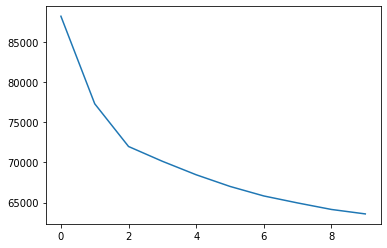

In [96]:
plt.plot(df_res['train_loss'][last])
plt.show()

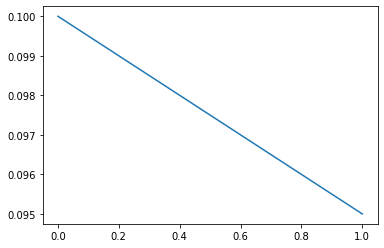

In [21]:
plt.plot(df_res['lr'][last])
plt.show()

# Evaluation

In [47]:
ranked_df = pd.DataFrame(columns=['pred_items_ranked', 'true_id'], index=[1,2,3])

In [48]:
ranked_df

,pred_items_ranked,true_id
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN


In [109]:
def rank_predictions(model, test_set, rank_at, multiprocessing=True):
    import eval_rank_bpr
    
    s = time.time()
    users = test_set.user_id.unique()
    items = test_set.item_id.unique()
    test_user_items = test_set.groupby('user_id')['item_id'].apply(list)
    ranked_df = pd.DataFrame(columns=['pred_items_ranked', 'true_id'], index=users)
    
    if multiprocessing:
        mp_splits = 4
        users_split = np.array_split(users, mp_splits)

        if __name__ == '__main__':
            pool = mp.Pool(processes = mp_splits)
            ranked = pool.map(eval_rank_bpr.eval_rank_bpr, [
                                                    [model, users_split[0], items, test_user_items, rank_at], 
                                                    [model, users_split[1], items, test_user_items, rank_at], 
                                                    [model, users_split[2], items, test_user_items, rank_at], 
                                                    [model, users_split[3], items, test_user_items, rank_at]
                                                            ])
            pool.close()

            for i in range(mp_splits):
                ranked_df = pd.concat([ranked_df, ranked[i]])
    
    else:
        pred_items_ranked = []
        true_items_list = []
        
        for u in users:
            user_item_pred_score = []
            true_items = []
            for true_item in test_user_items.loc[u]:
                true_items.append(true_item)

            predictions = np.dot(model['p'][u], model['q'].T)
            ids = np.argpartition(predictions, -rank_at)[-rank_at:]
            best_ids = np.argsort(predictions[ids])[::-1]
            best = ids[best_ids]
            
            pred_items_ranked.append(best)
            true_items_list.append(true_items)

        ranked_df['pred_items_ranked'] = pred_items_ranked
        ranked_df['true_id'] = true_items_list

    print('Ranking time:', round(time.time() - s,2))
    
    return ranked_df

In [110]:
def get_metrics(ranked_df, steps, max_rank):
    s = time.time()
    ranks_at = [1] + [i for i in range(steps, max_rank + steps, steps)]
    hitcounts = []
    recs_at = []
    precs_at = []
    metrics = pd.DataFrame(columns=['rank_at', 'hitcounts', 'recall', 'precision'])
    for rank in ranks_at:
        hitcount = 0
        for i, row in ranked_df.iterrows():
            hitcount +=  len(set(row['true_id']) & set(row['pred_items_ranked'][:rank]))

        prec_at = hitcount / rank / len(ranked_df)
        rec_at = hitcount / len(ranked_df.iloc[0]['true_id']) / len(ranked_df)

        hitcounts.append(hitcount)                     
        recs_at.append(rec_at)
        precs_at.append(prec_at)

    metrics['rank_at'] = ranks_at
    metrics['hitcounts'] = hitcounts
    metrics['recall'] = recs_at
    metrics['precision'] = precs_at
    print('Obtaining metrics time:', round(time.time() - s,2))
    return metrics

## Ranking and Metrics

In [57]:
len(test_set.user_id.unique())

1213

In [58]:
model = {'p':df_res['p'][1], 'q':df_res['q'][1]}

In [60]:
rank_at = 20
ranked_df = rank_predictions(model, test_set, rank_at, True)

steps = 5
metrics = get_metrics(ranked_df, steps, rank_at)

Ranking time: 2.8052830696105957
Obtaining metrics time: 1.1742150783538818


In [ ]:
metrics

### Store Metrics

In [ ]:
metrics.to_pickle(path + 'Results/BPR/metrics_' + file_name)

In [91]:
pd.read_pickle(path + 'Results/metrics_' + file_name)

,rank_at,hitcounts,recall,precision
0,1,0,0.000000,0.000000
1,5,0,0.000000,0.000000
2,10,0,0.000000,0.000000
3,15,1,0.000824,0.000055
4,20,1,0.000824,0.000041


## Visualise Results

In [ ]:
metrics

In [ ]:
plt.plot(metrics['rank_at'], metrics['precision'])
plt.xlabel('Rank')
plt.ylabel('precision@')
plt.title('Precision for different rank values')
plt.show()

In [ ]:
plt.plot(metrics['rank_at'], metrics['recall'])
plt.xlabel('Rank')
plt.ylabel('recall@')
plt.title('Recall')
plt.show()

# Sequential Run

In [126]:
def seq_run(file_names, file_paths, all_params):
    runs = 0
    for file_name, file_path, params in zip(file_names, file_paths, all_params):
        # Init 
        print('\n\n', '='*50)
        df = pd.read_pickle(file_path + file_name)
        df['item_id'] = df.item.astype('category').cat.codes
        df['user_id'] = df.user.astype('category').cat.codes
        
        total_users = len(df.user_id.unique())
        total_items = len(df.item_id.unique())
        
        test_users = int(0.1*total_users) # Number of users to be used for testing
        test_last_items = 1 # Items to be removed from test users in train set and used in test set

        val_users = int(0.1*total_users)
        val_last_items = 1

        train_set, test_set = leave_last_x_out(df, test_users, test_last_items)
        train_set, val_set = leave_last_x_out(train_set, val_users, val_last_items)
        
        train_users = len(train_set.user_id.unique())
        
        print('Run:', runs + 1, '\nFile:', file_name,
              '\nTrain users:', train_users, '\nTest users:', test_users,
              '\nVal users:', val_users)
        
        # Model Run
        params['sample_size'] = 0.5*len(train_set)
        model = BPR(total_users, total_items, params)
        model.fit(train_set, val_set)
        
        log_path = path + 'Results/BPR/'
        res_name = 'BPR_models'
        store_results(model.model, log_path, res_name, file_name)
        
        rank_at = 20
        steps = 5
        
        ranked_df = rank_predictions(model.model, test_set, rank_at, False)
        metrics = get_metrics(ranked_df, steps, rank_at)
        print('Results')
        print(metrics)
        
        metrics.to_pickle(path + 'Results/BPR/metrics_' + file_name)
        
        runs += 1

In [122]:
params_amazon_001 = {
"nolf":20, # Size of latent feature vectors
"n_iterations":40, # Depends on number of items and users
"sample_size":1, # Adjusted in loop to 0.5*len(train_set)
"seed":1234,
"alpha":0.1, # Learning rate
          
#Regularizers
"reg_user":0.05, # should be in proportion to the number of items 
"reg_item":0.05,
}

In [123]:
params_ml_001 = {
"nolf":20, #Size of latent feature vectors
"n_iterations":20, # Depends on number of items and users
"sample_size":1, # Adjusted in loop to 0.5*len(train_set)
"seed":1234,
"alpha":0.1, # Learning rate
          
#Regularizers
"reg_user":0.5,
"reg_item":0.5,
}

In [124]:
file_names = ['Amazon_001_users', 'ML_001_users']
file_paths = [path + 'Data/Amazon/', path + 'Data/ML/']
all_params = [params_amazon_001, params_ml_001]

seq_run(file_names, file_paths, all_params)




Run: 1 
File: Amazon_001_users 
Train users: 12127 
Test users: 1213
Creating 40 samples of length 51609
iteration: 0  loss: 0.711216  val AUC: 0.5028830665972969
iteration: 1  loss: 0.704144  val AUC: 0.5092721543820596
iteration: 2  loss: 0.697702  val AUC: 0.5177078578592073
iteration: 3  loss: 0.691078  val AUC: 0.525312602878858
iteration: 4  loss: 0.682936  val AUC: 0.5323212868998314
iteration: 5  loss: 0.674216  val AUC: 0.5384024363720707
iteration: 6  loss: 0.666345  val AUC: 0.5420130682784807
iteration: 7  loss: 0.657289  val AUC: 0.5467043275066787
iteration: 8  loss: 0.648233  val AUC: 0.5499021762334384
iteration: 9  loss: 0.638965  val AUC: 0.5512302781165304
iteration: 10  loss: 0.629605  val AUC: 0.5551451822438871
iteration: 11  loss: 0.619804  val AUC: 0.5573460681401993
iteration: 12  loss: 0.609015  val AUC: 0.5583488913652096
iteration: 13  loss: 0.599605  val AUC: 0.557782092199662
iteration: 14  loss: 0.590952  val AUC: 0.5583222252319546
iteration: 15  loss

# Appendix

In [ ]:
# df = pd.read_pickle('Data/amazon_clothing_shoes_jewelry_data')
# users = df.user.unique()
# to_keep = users[:300000]

# user_indices = df.groupby('user')['index'].apply(list)
# to_keep_indices = []
# for u in user_indices[to_keep]:
#     to_keep_indices.extend(u)

# new_df = df_og.loc[to_keep_indices]
# len(to_keep_indices)

## standard SVD model

In [ ]:
class SVD:
    """" All functions used to run, test, plot and store the
    Singular Value Decomposition Model"""

    def __init__(self, params, total_users, total_items):
        self.nolf = params['nolf']
        self.n_epochs = params['n_epochs']
        self.alpha = params['alpha']
        self.alpha_b = params['alpha_b']
        self.alpha_cb = params['alpha_cb']
        self.use_bias = params['use_bias']
        self.use_impl_fb = params['use_impl_fb']
        self.use_color = params['use_color']
        self.use_weight_ver = params['use_weight_ver']
        self.bu_reg = params['bu_reg']
        self.bi_reg = params['bi_reg']
        self.pu_reg = params['pu_reg']
        self.qi_reg = params['qi_reg']
        self.x_reg = params['x_reg']
        self.cb_reg = params['cb_reg']
        self.ver_weight = params['ver_weight']
        self.stop = params['stop']
        self.random_state = params['random_state']
        self.total_users = total_users
        self.total_items = total_items
        self.params = params
        self.mu = 0 
        self.N = []
        self.N_test = []
        self.t = pd.DataFrame()
        self.c = pd.DataFrame()
        self.F = pd.DataFrame()

        self.train_data = pd.DataFrame()
        self.test_data = pd.DataFrame()
        self.val_data = pd.DataFrame()
        self.train_time = 0
        self.best_model = {}
        self.model = {}
        self.test_results = {}

    def fit(self, train_data, val_data=[], verbose=1, plot=True, plot_name=''):
        self.train_data = train_data
        self.val_data = val_data
        self.SVD(train_data=train_data, val_data=val_data, verbose=verbose, plot=plot, plot_name=plot_name)
        return self

    
###############################################################################################
    
    def SVD(self, train_data, val_data, verbose, plot, plot_name):
        """"The SVD algorithm with sgd
        input: rating dataset with columns:['rating', 'user_id', 'item_id']
        output: the resulting p, q, bi, bu matrices"""
        self.mu = self.create_mu(train_data)
        train_matrix = self.create_matrix(train_data, self.total_users, self.total_items)
        
        tuples_train = [tuple(x) for x in train_data[['new_user_id', 'new_item_id', 'rating']].to_numpy()]
        
        p = np.random.normal(0, .1, (total_users, self.nolf))  # users
        q = np.random.normal(0, .1, (total_items, self.nolf))  # items
        
        # user and item biases
        b_user = np.zeros(total_users)
        b_item = np.zeros(total_items)
        
        # using color (pareto split (0,1,2)) attribute bias
        if self.use_color:
            print('Creating F and c, for incorporating color bias')
            self.F, self.c = self.init_color(train_data)

        # implicit fb rated, not rated
        x = np.random.normal(0, .1, (total_items, self.nolf))
        impl_fb_u = np.zeros(self.nolf)
        if self.use_impl_fb:
            print('Creating N, for incorporating implicit feedback')
            self.N = train_data.groupby('new_user_id')['new_item_id'].apply(list)
        
        # 0.5 weight on the errors of verified = False user item combinations
        if self.use_weight_ver:
            i_verified = train_data.set_index(['new_user_id', 'new_item_id'])['verified']
            i_verified = i_verified.loc[~i_verified.index.duplicated(keep='first')]
        
        sqrt_Nu = 0
        cb = 0
        rmses = []
        val_rmses = []
        smallest_val_rmse = 10000
        val_rmse = "na"
        start = time.time()
        for epoch in range(self.n_epochs):
            total_sq_error = 0
            for u, i, r_ui in tuples_train:
                u = int(u)
                i = int(i)
                
                if self.use_impl_fb:
                    impl_fb_u = np.zeros(self.nolf)
                    sqrt_Nu = np.sqrt(len(self.N[u]))
                    for j in self.N[u]:
                        impl_fb_u += x[j] / sqrt_Nu

                if self.use_color and epoch > 5:
                    F_ui =  self.F[u,i] #Set of items associated with i and rated by u
                    u_mu = self.mu + b_user[u]
                    sqrt_F_ui = np.sqrt(len(F_ui))
                    for index, f in enumerate(F_ui):
                        r_uf = train_data[(train_data['new_user_id']==u) & (train_data['new_item_id']==f)]['rating'].iloc[0]
                        cb += (r_uf - u_mu) * self.c[u,i][index]
                    cb /=  sqrt_F_ui
                        
                if self.use_bias:   
                    error = r_ui - ((self.mu + b_user[u] + b_item[i] + cb) + np.dot(p[u] + impl_fb_u, q[i]))
                    if self.use_weight_ver and not i_verified[u,i]:
                        error = self.ver_weight * error
                    
                    b_user[u] += self.alpha_b * (error - self.bu_reg * b_user[u])
                    b_item[i] += self.alpha_b * (error - self.bi_reg * b_item[i])
                else:
                    error = r_ui - np.dot(p[u], q[i])

                p[u] += self.alpha * (error * q[i] - self.pu_reg * p[u])
                q[i] += self.alpha * (error * (p[u] + impl_fb_u) - self.qi_reg * q[i])
                total_sq_error += np.square(error)
            
                if self.use_impl_fb:
                    for j in self.N[u]:
                        x[j] += self.alpha * (error * q[i] / sqrt_Nu - self.x_reg * x[j])
                
                if self.use_color and epoch > 5:
                    for index, f in enumerate(F_ui):
                        r_uf = train_data[(train_data['new_user_id']==u) & (train_data['new_item_id']==f)]['rating'].iloc[0]
                        u_mu = self.mu + b_user[u]
                        self.c[u,i][index] += self.alpha_cb * (error * (1/sqrt_F_ui) * (r_uf - u_mu) - self.cb_reg * self.c[u,i][index])
                
            rmse = np.sqrt(total_sq_error / len(tuples_train))
            rmses.append(rmse)
            
            self.model = {'p': p, 'q': q, 'bu':b_user, 'bi':b_item, 'cbu': self.c, 'x':x, 'rmse':rmses, 'val_rmse':val_rmses}
            
            # Validation
            if len(val_data) > 0:
                new_val_rmse = self.test(val_data, val=True)
                val_rmses.append(new_val_rmse)
                if new_val_rmse < smallest_val_rmse:
                    smallest_val_rmse = new_val_rmse
                    self.best_model = copy.deepcopy(self.model)
                val_rmse = new_val_rmse
                
            # Epoch Printing
            if epoch % verbose == 0:
                if len(val_data) > 0:
                    print('Epoch:', epoch, '  RMSE:', rmse, ' Val_RMSE:', val_rmse)
                else:
                    print('Epoch:', epoch, '  RMSE:', rmse)
            
            if self.stop and val_rmses[-2:][0] < val_rmse:
                print('BREAK: Validation set not improving anymore')
                break
                
        if plot:
            self.plot_rmse(rmses, val_rmses, plot_name)

        self.train_time = time.time() - start
        self.model = {'p': p, 'q': q, 'bu':b_user, 'bi':b_item, 'cbu': self.c, 'x':x, 'rmse':rmses, 'val_rmse':val_rmses}
#################################################################################################

    def init_color(self, data_set):
        self.t = data_set.groupby(['new_user_id', 'par_col2'])['new_item_id'].apply(list)
        F = data_set.groupby(['new_user_id', 'new_item_id'])['par_col2'].apply(self.sim_items)
        c = data_set.groupby(['new_user_id', 'new_item_id'])['par_col2'].apply(self.sim_items, random=True)
        return F, c

    def sim_items(self, x, random=False):
        u_id = x.name[0]
        col = x.iloc[0]
        if random:
            return np.random.normal(0,.1,len(self.t[u_id, col]))
        return self.t[u_id, col]
    
    def create_matrix(self, X_train, n_users, n_items):
        r = X_train['new_user_id']
        c = X_train['new_item_id']
        d = X_train['rating']
        train_matrix = sparse.coo_matrix((d, (r, c)), shape=(n_users, n_items))
    
        return train_matrix.tocsr()
    
    def create_mu(self, train_set):
        # Better mean calculation according to https://sifter.org/~simon/journal/20061211.html
        va = train_set.groupby('new_user_id')['rating'].mean().var() #variance mean ratings users
        vb = train_set.groupby('new_item_id')['rating'].mean().var() #variance mean ratings items
        k = va/vb #variance proportion
        better_mu = (train_set['rating'].mean() + train_set['rating'].sum()) / (k+len(train_set))
        return better_mu
    
    def plot_rmse(self, rmse, val_rmses=[], plot_name=''):
        plt.plot(np.arange(len(rmse)), rmse)
        if len(val_rmses) > 0:
            plt.plot(np.arange(len(val_rmses)), val_rmses, color='red')
        plt.title('RMSE')
        plt.xlabel('epoch')
        plt.ylabel('RMSE')
        plt.legend(['Train', 'Validation'])
        if len(plot_name) > 0:
            plt.savefig('Plots/' + plot_name + '.png')
        plt.show()

    def test(self, test_data, val=False):
        if not val:
            self.test_data = test_data
        tuples_test = [tuple(x) for x in test_data[['new_user_id', 'new_item_id', 'rating']].to_numpy()]
        test_matrix = self.create_matrix(test_data, self.total_users, self.total_items)
        
        if self.use_impl_fb and val:
            self.N_test = self.val_data.groupby('new_user_id')['new_item_id'].apply(list)
        elif self.use_impl_fb:
            self.N_test = self.test_data.groupby('new_user_id')['new_item_id'].apply(list)
            
        total_error = 0
        estimates = []
        for u, i, r_ui in tuples_test:
            u = int(u)
            i = int(i)
            est = self.estimate(u, i, test_matrix, test_data)
            estimates.append(est)
            total_error += np.square(r_ui - est)
        
        rmse = np.sqrt(total_error / len(tuples_test))
        
        if not val:
            self.test_results = {'rmse': rmse, 'estimates':estimates}
            print('RMSE on test set:', self.test_results['rmse'])
        else:
            return rmse

    def estimate(self, u, i, test_matrix, test_data):
        est = self.mu + self.model['bu'][u] + self.model['bi'][i]
        impl_fb_u = np.zeros(self.nolf)
        cb = 0
        if u in self.train_data['new_user_id'] and i in self.train_data['new_item_id']:
            
            if self.use_impl_fb and u in self.N.index:
                sqrt_Nu = np.sqrt(len(self.N[u]))
                for j in self.N[u]:   
                    impl_fb_u += self.model['x'][j] / sqrt_Nu
            
            if self.use_color and (u,i) in self.model['cbu']:
                F_ui =  self.F[u,i] #Set of items associated with i and rated by u
                u_mu = self.mu + self.model['bu'][u]
                sqrt_F_ui = np.sqrt(len(F_ui))
                for index, f in enumerate(F_ui):
                    r_uf = self.train_data[(self.train_data['new_user_id']==u) & (self.train_data['new_item_id']==f)]['rating'].iloc[0]
                    cb += (r_uf - u_mu) * self.model['cbu'][u,i][index]
                cb /=  sqrt_F_ui
                
            est += cb + np.dot(self.model['p'][u] + impl_fb_u, self.model['q'][i])

        return est
    
    def store_results(self, log_path, res_name, user_thres, item_thres):
        train_size = round((len(self.train_data) / (len(self.train_data) + len(self.test_data) + len(self.val_data))),1)
        test_size = round((len(self.test_data) / (len(self.train_data) + len(self.test_data) + len(self.val_data))),1)
        val_size = round((len(self.val_data) / (len(self.train_data) + len(self.test_data) + len(self.val_data))),1)
        
        result_info = {'RMSE_test': self.test_results['rmse'], 'train_speed': round(self.train_time,2)}
        other_info = {'u_thres': user_thres,'i_thres': item_thres, 'train_size':train_size, 'test_size':test_size, 'val_size':val_size, 'train_rmse':self.model['rmse'], 'val_rmse':self.model['val_rmse']}
        final_log = dict(result_info, **self.params, **other_info)

        if not os.path.exists(log_path + res_name):
            df_results = pd.DataFrame(columns=final_log.keys())
            print('new results created')

        else:
            df_results = pd.read_pickle(log_path + res_name)
            print('results added')

        df_results = df_results.append(final_log, ignore_index=True)
        pd.to_pickle(df_results, log_path + res_name)

In [ ]:
class BPR():
    def __init__(self, total_users, total_items, params):
        self.total_users = total_users
        self.total_items = total_items
        self.nolf = params['nolf']
        self.n_iterations = params['n_iterations']
        self.alpha = params['alpha']
        self.reg_user = params['reg_user']
        self.reg_item = params['reg_item']
        self.reg_bias = params['reg_bias']
        self.alpha_decay = self.alpha / self.n_iterations
        self.model = {'loss_list':[], 'learning_rate':[]}
        
    def fit(self, train_set, val_set, val_rank, batch_size=1000):
        #Init
        s = time.time()
        self.model['p'] = np.random.normal(0, .1, (self.total_users, self.nolf))  # users
        self.model['q'] = np.random.normal(0, .1, (self.total_items, self.nolf))  # items
        self.model['b'] = np.zeros(self.total_items)
        
#         val_prec_at = []
#         val_rec_at = []
#         val_hitcount = []
        
        # Create samples 
        n_sgd_samples = len(train_set) * self.n_iterations
        
        z = 0
        self.model['train_time'] = 0
        print('init and sampling done:', time.time() - s, 'seconds')
        for i in range(self.n_iterations):
            sgd_users, sgd_pos_items, sgd_neg_items = self.user_sampling(train_set, n_sgd_samples)
        
        while (z+1)*batch_size < n_sgd_samples:
            s_it = time.time()
            it_loss = self.train(sgd_users[z*batch_size:(z+1)*batch_size], sgd_pos_items[z*batch_size:(z+1)*batch_size], sgd_neg_items[z*batch_size:(z+1)*batch_size])
            
            if z > 0:
                self.update_alpha(it_loss)
            
            z += 1
            self.model['loss_list'].append(it_loss) 

#             rec_at, prec_at, hitcount = self.eval(val_set, val_rank)
            t_it = time.time()- s_it
            self.model['train_time'] += t_it
            print('batch:', z, ' loss:', round(it_loss,4), 'iteration time:', round(t_it/2,2))#, ' val prec@' + str(val_rank), ':', round(prec_at,5), ' val rec@' + str(val_rank), ':', round(rec_at,5), '  Hits:', hitcount)#'  alpha:', self.alpha)
    
#             val_prec_at.append(prec_at)
#             val_rec_at.append(rec_at)
#             val_hitcount.append(hitcount)
            
#         self.model['val_prec_at'] = val_prec_at
#         self.model['val_rec_at'] = val_rec_at
#         self.model['val_hitcount'] = val_hitcount
        
        
    def create_matrices(self, data):
        r = data['new_user_id']
        c = data['new_item_id']
        d = data['rating']
        m = sparse.csr_matrix((d, (r, c)), shape=(self.total_users, self.total_items))
        m_ones = m.copy()
        m_ones[m_ones > 0] = 1                 
        return m, m_ones
    
    def sigmoid(self, x):
        return 1 / (1 + math.exp(-x))
    
    def user_sampling(self, data, n_samples):
        train_ratings, train_ones = self.create_matrices(train_set)
        user_items = train_set.groupby('new_user_id')['new_item_id'].apply(list)
        train_users  = train_set.new_user_id.unique()
        train_items = train_set.new_item_id.unique()
        
        sgd_users, sgd_pos_items, sgd_neg_items = [], [], []
        for sample in range(n_samples):
            u = np.random.choice(train_users)
            i = random.choice(user_items[u])

            j = int(np.random.choice(train_items)) # neg item
#             j_v = int(train_ones[u,j]) # Value, NEEDED?

            while j in user_items[u]: # j cannot be the same item or an item with a 1
                j = int(np.random.choice(train_items))
#                 j_v = int(train_ones[u,j])
            
            sgd_users.append(u)
            sgd_pos_items.append(i)
            sgd_neg_items.append(j)
            
        return sgd_users, sgd_pos_items, sgd_neg_items
        
    def train(self, users, pos_items, neg_items):
        for u, i, j in zip(users, pos_items, neg_items):
            pos_item_pred = self.model['b'][i] + np.dot(self.model['p'][u], self.model['q'][i].T)
            neg_item_pred = self.model['b'][j] + np.dot(self.model['p'][u], self.model['q'][j].T)
            diff = pos_item_pred - neg_item_pred

            loss_value = - np.log(self.sigmoid(diff)) #NEGATIVE?
            regulariser = self.reg_user * np.dot(self.model['p'][u], self.model['p'][u]) + self.reg_item * np.dot(self.model['q'][i],self.model['q'][i]) + self.reg_item/10 * np.dot(self.model['q'][j], self.model['q'][j]) + self.reg_bias * (self.model['b'][i]**2 + self.model['b'][j]**2) 
            it_loss = loss_value + regulariser

            diff_deriv = self.sigmoid(- diff)
            
            #SGD update
            for f in range(self.nolf): # update each factor (see notes for derivatives)
                self.model['p'][u,f] += self.alpha * (diff_deriv * (self.model['q'][i,f] - self.model['q'][j,f]) - self.reg_user * self.model['p'][u,f])
                self.model['q'][i,f] += self.alpha * (diff_deriv * self.model['p'][u,f] - self.reg_item * self.model['q'][i,f])
                self.model['q'][j,f] += self.alpha * (diff_deriv * (-self.model['p'][u,f]) - self.reg_item / 10 * self.model['q'][j,f])
                self.model['b'][i] += self.alpha * (diff_deriv * self.reg_bias * self.model['b'][i])
                self.model['b'][j] += self.alpha * (- diff_deriv * (- self.reg_bias) * self.model['b'][j])

#                 it_loss += self.reg_user * self.model['p'][u,f] * self.model['p'][u,f] + self.reg_item * self.model['q'][i,f] * self.model['q'][i,f] + self.reg_item * self.model['q'][j,f] * self.model['q'][j,f]
        return it_loss
        
    def update_alpha(self, it_loss):
        last_loss = self.model['loss_list'][-1]
        if(last_loss < it_loss): #bold driver
            self.alpha = 0.5 * self.alpha
            return
        
        self.alpha = (1 - self.alpha_decay) * self.alpha
        self.model['learning_rate'].append(self.alpha)
        
    def eval(self, val_set, max_rank):
        import eval_rank
        val_ratings, val_ones = create_matrices(val_set, self.total_users, self.total_items)
        result = self.model
        users = val_set.new_user_id.unique()
        items = val_set.new_item_id.unique()

        s = time.time()
        rank_at = max_rank
        mp_splits = 4
        users_split = np.array_split(users, mp_splits)

        if __name__ == '__main__':
            pool = mp.Pool(processes = mp_splits)
            ranked = pool.map(eval_rank.eval_rank, [[result, users_split[0], items, val_ones, rank_at], 
                                                    [result, users_split[1], items, val_ones, rank_at], 
                                                    [result, users_split[2], items, val_ones, rank_at], 
                                                    [result, users_split[3], items, val_ones, rank_at]])
            pool.close()

            ranked_df = pd.DataFrame()

            for i in range(mp_splits):
                ranked_df = pd.concat([ranked_df, ranked[i]])

            t = time.time() - s
            hitcount = 0
            for u in ranked_df.index:
                hitcount += len(set(ranked_df.loc[u]['true_id']) & set(ranked_df.loc[u]['pred_items_ranked']))

            prec_at =  hitcount / (len(ranked_df) * rank_at)
            rec_at = hitcount / (len(ranked_df) * len(ranked_df.loc[0]['true_id']))
            
            return prec_at, rec_at, hitcount
#             print(t)